### 1. Import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,total_moves,w_captures,w_checks,w_castles,w_promotions,b_captures,b_checks,b_castles,...,check_diff,total_promotions,promotion_diff,aggression_diff,both_castled,game_length_short,game_length_medium,game_length_long,tactical_intensity,white_more_aggressive
0,2504,2371,49,4,0,1,0,4,0,1,...,0,0,0,-0.006667,1,0,1,0,0.163265,0
1,2487,2596,71,8,10,1,0,7,2,1,...,8,0,0,0.242857,1,0,0,1,0.380282,1
2,2915,2921,59,4,0,1,0,4,0,1,...,0,0,0,-0.004598,1,0,1,0,0.135593,0
3,2542,2433,71,10,1,1,0,9,3,0,...,-2,0,0,-0.037302,0,0,0,1,0.323944,0
4,2473,2658,56,5,3,1,0,6,0,1,...,3,0,0,0.071429,1,0,1,0,0.250000,1


### 2. Prepare data

In [3]:
X = df.drop("ResultNumeric", axis=1)
y = df["ResultNumeric"]

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3267529, 36)
Target: (3267529,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y,
)

#### Scale feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver="saga",
    random_state=42,
    n_jobs=-1,
)

In [7]:
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(
    f"Training completed in {training_time:.2f} seconds ({training_time / 60:.2f} minutes)"
)

Training completed in 789.70 seconds (13.16 minutes)


### 5. Evaluate

In [8]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)\n")

print("Classification Report: \n")
print(
    classification_report(
        y_test, y_pred, target_names=["Black Win", "Draw", "White Win"]
    )
)

Accuracy: 0.7372 (73.72%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.73      0.76      0.75    267653
        Draw       0.69      0.45      0.55     84330
   White Win       0.75      0.79      0.77    301523

    accuracy                           0.74    653506
   macro avg       0.73      0.67      0.69    653506
weighted avg       0.74      0.74      0.73    653506



### 6. Confusion Matrix

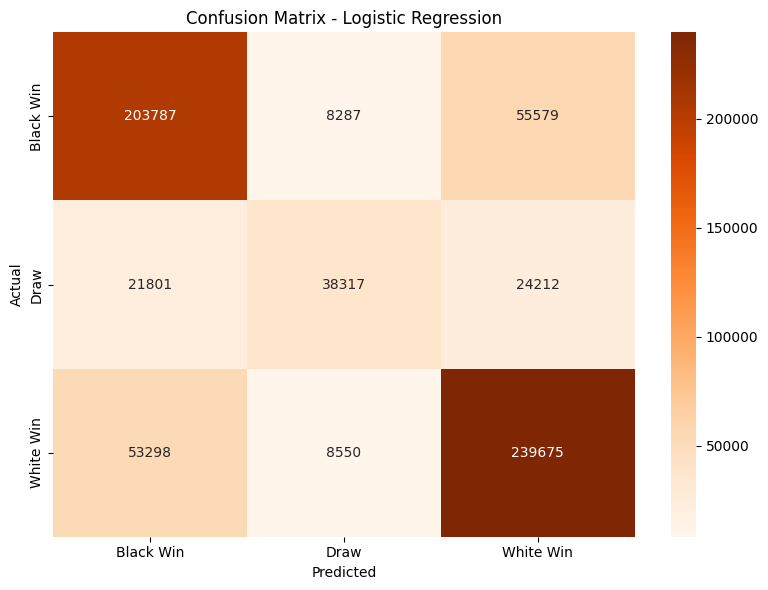

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Black Win", "Draw", "White Win"],
    yticklabels=["Black Win", "Draw", "White Win"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

### 7. Coefficients (Feature importance for linear models)

                  Feature  Coefficient
34     tactical_intensity     0.797123
14     b_aggression_score     0.732625
11         w_capture_rate     0.588000
12         b_capture_rate     0.580453
23           capture_diff     0.573573
13     w_aggression_score     0.554164
21          TerminationID     0.346936
3              w_captures     0.238686
7              b_captures     0.229941
24       capture_diff_abs     0.227800
22         total_captures     0.184916
19   WhiteRatingAdvantage     0.169777
29        aggression_diff     0.154931
35  white_more_aggressive     0.133080
1                BlackElo     0.121318
0                WhiteElo     0.117622
17              AvgRating     0.101386
6            w_promotions     0.100096
26             check_diff     0.092079
28         promotion_diff     0.090971
31      game_length_short     0.088880
4                w_checks     0.086500
8                b_checks     0.077470
16             RatingDiff     0.073437
27       total_promotions

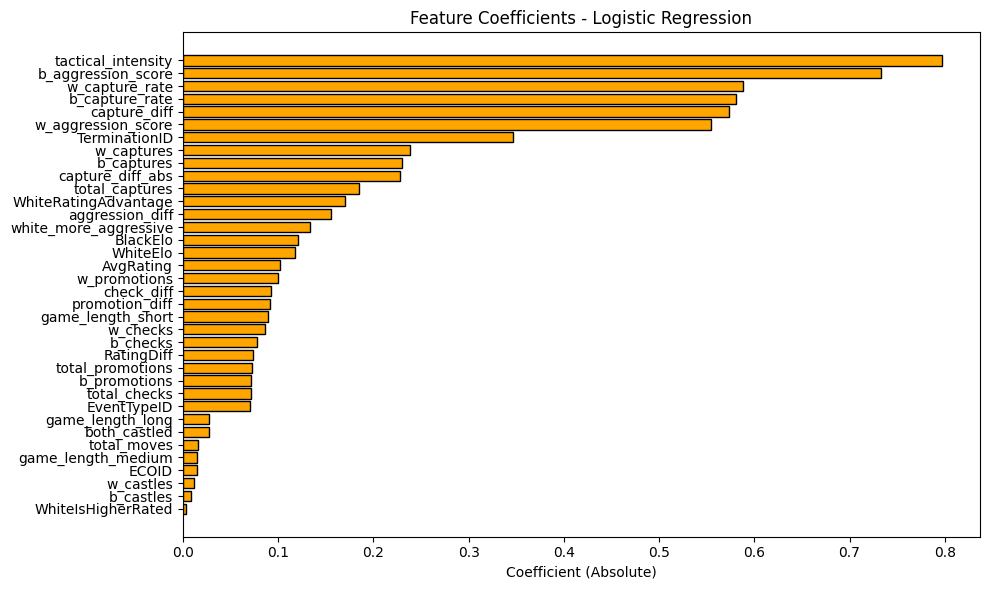

In [10]:
coef_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "Coefficient": np.abs(lr_model.coef_).mean(axis=0),  # Average across classes
    }
).sort_values("Coefficient", ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="orange", edgecolor="black")
plt.xlabel("Coefficient (Absolute)")
plt.title("Feature Coefficients - Logistic Regression")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()